In [8]:
from itertools import combinations
import torch
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'mps')

In [2]:
def run(initial, rule, steps=100):
    """
    Run the cellular automaton.

    :param rule_fn: A function that defines the rule to apply.
    :param steps: Number of steps to run.
    :param initial: Initial condition.
    :return: History of states.
    """

    history = torch.empty((steps, *initial.shape), dtype=initial.dtype, device=initial.device)
    history[0] = initial
    for i in range(1, steps):
        history[i] = rule(history[i-1])
    return history[1:]

In [3]:
import matplotlib.pyplot as plt
import math

CMAP = 'viridis'

def plot_image(image_data, ax=None, title=None, cmap='gray', figsize=(20, 12)):
    """
    Helper function to plot a single image or a list of images. 
    Creates a new figure and axis if not provided.

    :param image_data: Tensor or list of tensors representing the image(s) to be plotted.
    :param ax: Optional matplotlib axis to plot on. Creates a new axis if None.
    :param title: Optional title for the plot.
    :param cmap: Color map for the image.
    """

    # Function to plot a single tensor
    def plot_single_tensor(tensor, ax, title=None):
        tensor = tensor.cpu()
        if tensor.dim() == 1:
            # Reshape 1D tensor to 2D for plotting
            tensor = tensor.view(1, -1)
        ax.imshow(tensor.numpy(), cmap=cmap)
        if title is not None:
            ax.set_title(title)
        ax.axis('off')

    if isinstance(image_data, list):
        # If input is a list, plot each tensor in a subplot
        num_images = len(image_data)
        fig, axes = plt.subplots(1, num_images, figsize=(num_images * 5, 5))
        for i, tensor in enumerate(image_data):
            plot_ax = axes[i] if num_images > 1 else axes
            plot_single_tensor(tensor, plot_ax, title=f"{title} {i+1}" if title else None)
    elif isinstance(image_data, torch.Tensor):
        # If input is a tensor, plot it directly
        if ax is None:
            fig, ax = plt.subplots(figsize=figsize)
        plot_single_tensor(image_data, ax, title)
    else:
        raise TypeError("image_data must be a torch.Tensor or a list of torch.Tensors")

    if ax is None:
        plt.show()

def plot_grid(images, titles=None, figsize=(20, 12), cmap=CMAP, grid_rows=None):
    """
    Plots a grid of images with optional titles.

    :param images: List of image tensors to plot.
    :param titles: Optional list of titles for each image.
    :param fig_size: Size of the figure.
    :param cmap: Color map for the images.
    """
    num_images = len(images)
    grid_rows = grid_rows or math.ceil(math.sqrt(num_images))
    grid_cols = math.ceil(num_images / grid_rows)
    fig, axs = plt.subplots(grid_rows, grid_cols, figsize=figsize, squeeze=False)

    for i in range(grid_rows):
        for j in range(grid_cols):
            idx = i * grid_cols + j
            ax = axs[i, j]
            if idx < num_images:
                plot_image(images[idx], ax, title=(titles[idx] if titles and idx < len(titles) else None), cmap=cmap)
            else:
                ax.axis('off')

    plt.tight_layout()
    plt.show()

In [4]:
def elementary_ca(rule, ruleset=('a', 'b', 'c')):
    """
    Generate a rule function for a given elementary cellular automata rule number and ruleset.

    :param rule_number: The rule number (0-255 for elementary cellular automata).
    :param ruleset: A tuple of cell identifiers indicating the cells to consider for the rule.
    :return: A function that applies the rule to a given state.
    """
    # Convert rule number to binary string and pad to 8 bits
    rule_binary = format(rule, '08b')
    
    # Mapping from cell identifiers to index offsets
    cell_to_index = {
        'a': -1, 'b': 0, 'c': 1, 'd': -1, 'e': 0, 'f': 1, 'g': -1, 'h': 0, 'i': 1,
        'aa': -2, 'bb': -1, 'cc': 0, 'dd': 1, 'ee': 2, 'ff': -2, 'gg': -1, 'hh': 1, 'ii': 2,
        'aaa': -3, 'bbb': -2, 'ccc': -1, 'ddd': 0, 'eee': 1, 'fff': 2, 'ggg': 3,
        'hhh': -3, 'iii': -2, 'jjj': 2, 'kkk': 3, 'lll': -3, 'mmm': -2, 'nnn': -1, 'ooo': 0, 'ppp': 1, 'qqq': 2, 'rrr': 3
    }

    def rule_fn(state):
        state_length = len(state)
        indices = torch.arange(state_length, device=state.device).unsqueeze(1) + torch.tensor([cell_to_index[cell] for cell in ruleset], device=state.device)
        indices = indices % state_length  # Wrap around for edge cells

        neighborhoods = state[indices]
        powers = torch.tensor([2 ** i for i in reversed(range(len(ruleset)))], device=state.device)
        neighborhood_indices = torch.sum(neighborhoods * powers, dim=1)

        # Apply the rule to each cell
        rule = torch.tensor([int(bit) for bit in rule_binary], dtype=torch.int32, device=state.device)
        next_state = rule[7 - neighborhood_indices]
        return next_state

    return rule_fn


def generate_rulesets(kernel, neighborhood):
    """
    Generate all possible 3-bit rulesets for a 3x3 kernel. (a, b, c) represents the top row or the Wolfram ruleset.
    a, b, c, and d are assumed to be already computed due to lefthand multiplication.
    f, g, h,and i are unknown and are count as 2-bits. 
    therefore rules can have 3 computed cells, or 1 computed and 1 superposed
    """
    computed_cells = ['a', 'b', 'c', 'd']
    superposed_cells = ['f', 'g', 'h', 'i']
    rule_types = list(combinations(computed_cells + superposed_cells, 2))
    standard_rule_types = list(combinations(computed_cells, 3))
    rule_types.extend(standard_rule_types)
    return rule_types

In [5]:
def coarse_grain(tensor, kernel_size, energy_func):
    """
    Apply a coarse graining to a 2D tensor, iterating based on energy levels of previous row kernels.

    Args:
    - tensor (torch.Tensor): The input 2D tensor.
    - kernel_size (int): The size of the square kernel (n x n).
    - energy_func (callable): Function to calculate the energy.

    Returns:
    - torch.Tensor: The coarse-grained tensor.
    """
    tensor = tensor.float()
    height, width = tensor.shape
    new_height, new_width = height // kernel_size, width // kernel_size
    coarse_grained = torch.empty((new_height, new_width), dtype=tensor.dtype)

    # Initialize an ordering for the first row (default left-to-right)
    prev_row_order = list(range(new_width))

    for i in range(new_height):
        current_row_energies = []
        for j in range(new_width):
            window = tensor[i*kernel_size:(i+1)*kernel_size, j*kernel_size:(j+1)*kernel_size]
            energy = energy_func(window)
            current_row_energies.append((energy, j))

        # Sort the energies to get the new order
        current_row_order = [x[1] for x in sorted(current_row_energies)]

        # Iterate over the kernels in the order defined by the previous row's energies
        for j in prev_row_order:
            window = tensor[i*kernel_size:(i+1)*kernel_size, j*kernel_size:(j+1)*kernel_size]
            coarse_grained[i, j] = energy_func(window)

        # Update the order for the next iteration
        prev_row_order = current_row_order

    return coarse_grained

In [6]:
class SeenPatternEnergyCalculator:
    def __init__(self):
        self.seen_patterns = {}

    def energy(self, window):
        window_key = tuple(map(tuple, window.tolist()))
        if window_key not in self.seen_patterns:
            self.seen_patterns[window_key] = len(self.seen_patterns)
        
        return self.seen_patterns[window_key]
    
    def __len__(self):
        return len(self.seen_patterns)

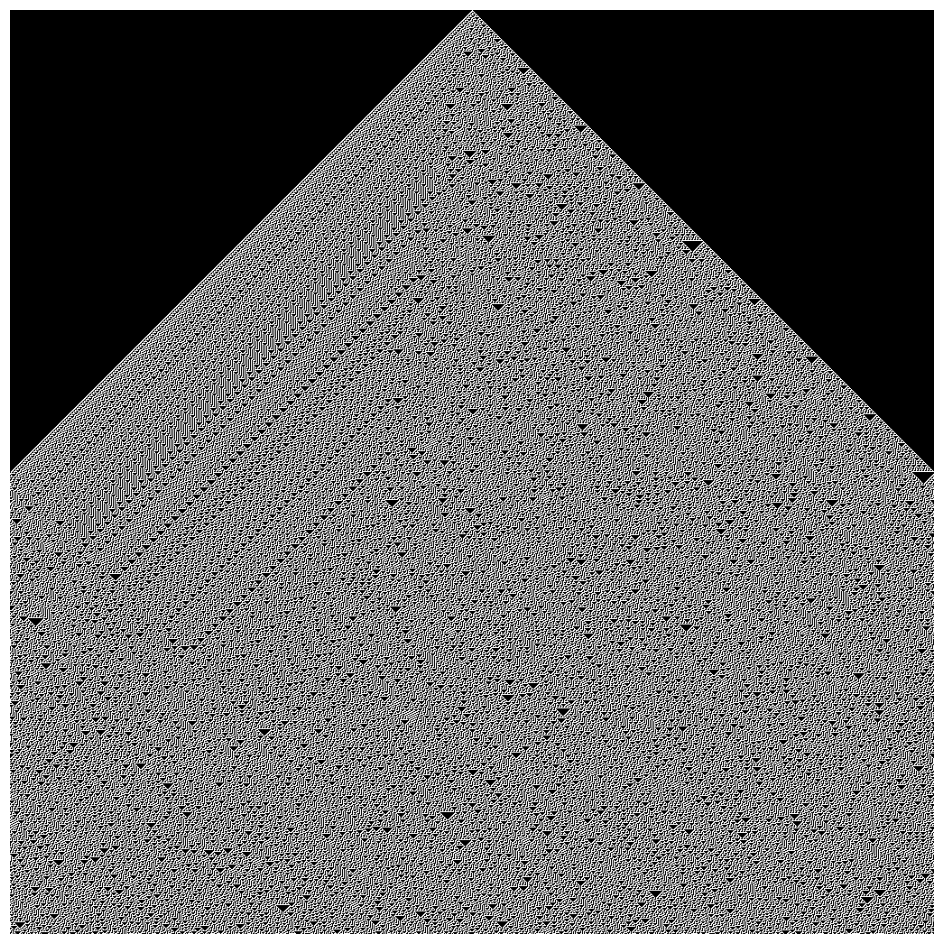

In [10]:
steps = 1024
width = 1024
rules = [elementary_ca(rule, ('a', 'b', 'c')) for rule in range(256)]
rule = 30
initial = torch.zeros(width, dtype=torch.int32, device=device)
initial[width // 2] = 1
states = [initial]
states += run(states[-1], rules[rule], steps=steps)
states = torch.stack(states)
plot_image(states)

/var/folders/_l/0xdngny15s9c5kt1gj7yd30r0000gn/T/ipykernel_82442/209445165.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plot_image(d2, cmap=plt.cm.get_cmap('nipy_spectral', len(ec)))


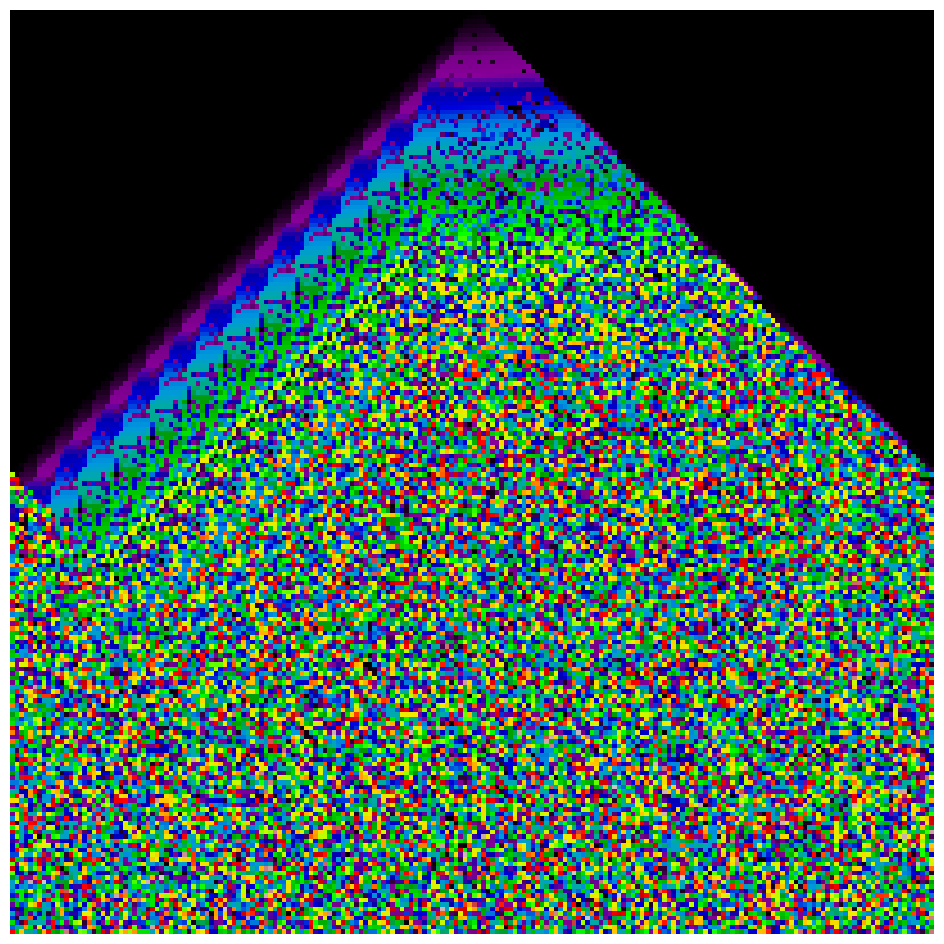

In [23]:
ec = SeenPatternEnergyCalculator()
d2 = coarse_grain(states, 5, ec.energy)
plot_image(d2, cmap=plt.cm.get_cmap('nipy_spectral', len(ec)))

12


/var/folders/_l/0xdngny15s9c5kt1gj7yd30r0000gn/T/ipykernel_82442/2976221839.py:54: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plot_image(d2, cmap=plt.cm.get_cmap('nipy_spectral', len(ec)))
/var/folders/_l/0xdngny15s9c5kt1gj7yd30r0000gn/T/ipykernel_82442/2976221839.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('nipy_spectral', num_patterns)


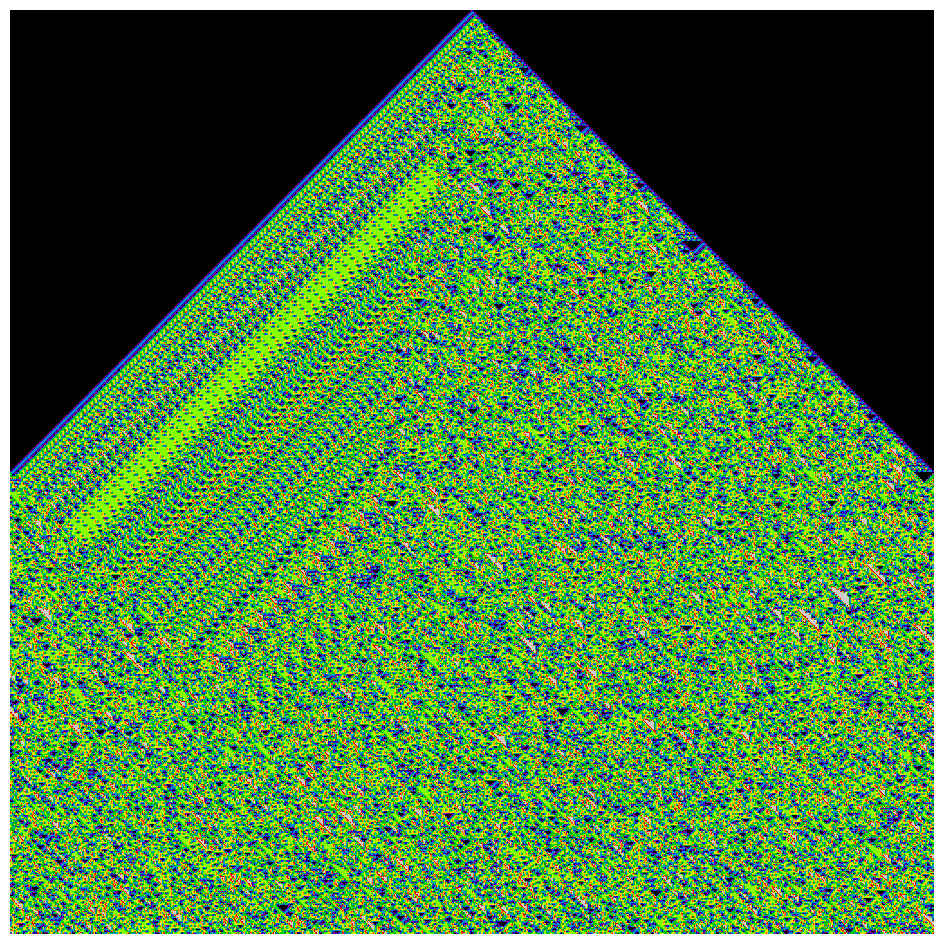

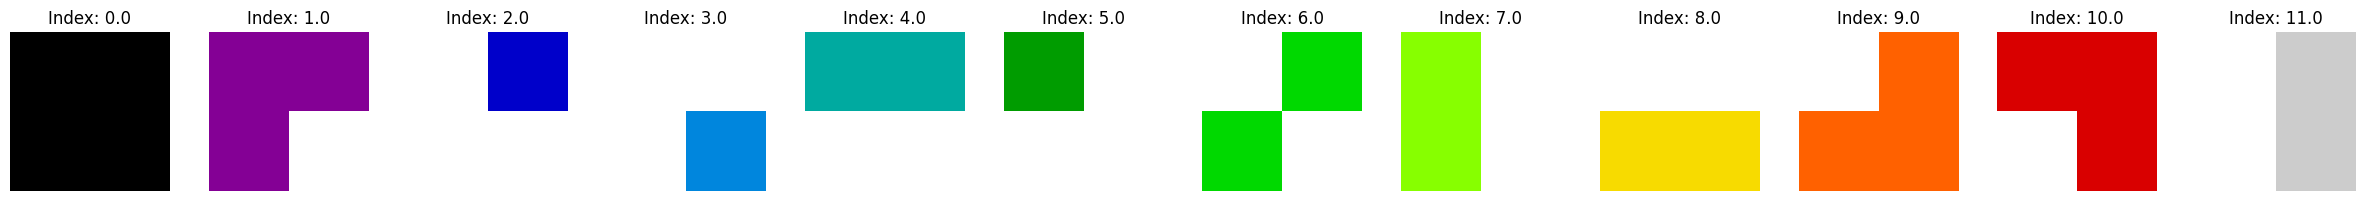

In [25]:
def prepare_data_for_plotting_torch(seen_patterns):
    # Number of patterns
    num_patterns = len(seen_patterns)
    
    # Determine the size of each pattern
    pattern_size = next(iter(seen_patterns.keys()))  # Get the first key to determine the size
    rows, cols = len(pattern_size), len(pattern_size[0])

    # Create tensors to hold all patterns and color mapping
    pattern_tensor = torch.zeros((num_patterns, rows, cols), dtype=torch.float32)
    color_mapping_tensor = torch.zeros(num_patterns, dtype=torch.float32)

    # Fill the tensor with patterns and their corresponding colors
    for i, (pattern, index) in enumerate(seen_patterns.items()):
        pattern_tensor[i, :, :] = torch.tensor(pattern, dtype=torch.float32)
        color_mapping_tensor[i] = index

    return pattern_tensor, color_mapping_tensor

def plot_grid_with_colored_subsets_torch(pattern_tensor, color_mapping_tensor):
    num_patterns = color_mapping_tensor.numel()
    pattern_size = pattern_tensor.shape[1:]

    # Create the colormap using Matplotlib
    cmap = plt.cm.get_cmap('nipy_spectral', num_patterns)

    # Initialize tensor to hold colored patterns
    colored_patterns = torch.ones((num_patterns, pattern_size[0], pattern_size[1], 3), dtype=torch.float32)

    for i in range(num_patterns):
        color = torch.tensor(cmap(color_mapping_tensor[i].item() / num_patterns)[:3], dtype=torch.float32)  # Ensure dtype is float32
        pattern = pattern_tensor[i]
        mask = (pattern == 0)  # Assuming we color where the pattern is 0

        # Apply color to the pattern
        colored_patterns[i][mask] = color

    # Plotting
    fig, axes = plt.subplots(1, num_patterns, figsize=(num_patterns * 2, 2))
    for i, ax in enumerate(axes):
        # Convert each pattern to numpy array for plotting
        ax.imshow(colored_patterns[i].numpy())
        ax.set_title(f'Index: {color_mapping_tensor[i].item()}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Using your SeenPatternEnergyCalculator instance 'ec'
ec = SeenPatternEnergyCalculator()
d2 = coarse_grain(states, 2, ec.energy)

print(len(ec))
plot_image(d2, cmap=plt.cm.get_cmap('nipy_spectral', len(ec)))
pattern_tensor, color_mapping_tensor = prepare_data_for_plotting_torch(ec.seen_patterns)
plot_grid_with_colored_subsets_torch(pattern_tensor, color_mapping_tensor)

In [16]:
def game_of_life(grid):
    grid_float = grid.float()
    kernel = torch.tensor([[1, 1, 1],
                           [1, 0, 1],
                           [1, 1, 1]], dtype=torch.float32, device=grid.device).view(1, 1, 3, 3)

    grid_padded = F.pad(grid_float.unsqueeze(0).unsqueeze(0), (1, 1, 1, 1), mode='circular')
    neighbor_sum = F.conv2d(grid_padded, kernel, padding=0).squeeze()
    return ((grid == 1) & ((neighbor_sum == 2) | (neighbor_sum == 3))) | ((grid == 0) & (neighbor_sum == 3))

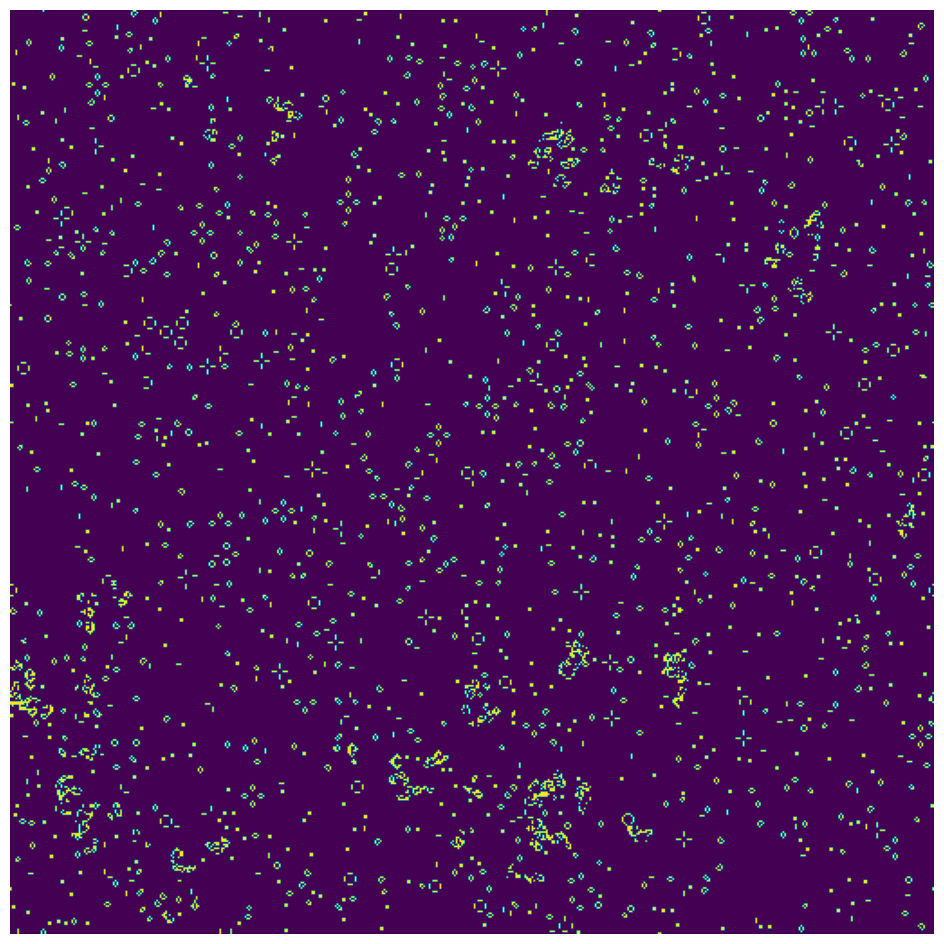

In [18]:
width = 512
num_epochs = 20
bs = 100
initial = torch.randint(0, 2, (width, width), dtype=torch.int32, device=device)
gof_states = [initial]
for n in range(num_epochs):
    gof_states += run(gof_states[-1], game_of_life, steps=bs)

plot_image(gof_states[-1].squeeze(), cmap=CMAP)